In [66]:

import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from utils.inflow_scaling_regression import scaling_site_matches, get_quarter
from utils.inflow_scaling_regression import prep_inflow_scaling_data, train_inflow_scale_regression_models
from utils.inflow_scaling_regression import predict_inflow_scaling

# PywrDRB directory
pywrdrb_dir = '../Pywr-DRB'
cms_to_mgd = 22.82

# List of all reservoirs able to be scaled
scaled_reservoirs = list(scaling_site_matches.keys())

# Quarters to perform regression over
quarters = ('DJF','MAM','JJA','SON')

In [67]:
# Load observed, NHM, and NWM flows
obs_flows = pd.read_csv(f'data/historic_unmanaged_streamflow_1900_2022_cms.csv', 
                        index_col=0, parse_dates=True)*cms_to_mgd
obs_flows.columns = [i.split('-')[1] for i in obs_flows.columns]
obs_flows.index = pd.to_datetime(obs_flows.index.date)

nhmv10_flows = pd.read_csv(f'{pywrdrb_dir}/input_data/modeled_gages/streamflow_daily_nhmv10_mgd.csv', 
                        index_col=0, parse_dates=True)


In [69]:
for node, flowtype_ids in scaling_site_matches.items():
    for flowtype, ids in flowtype_ids.items():
        if 'nhm' in flowtype:
            data = nhmv10_flows.copy()
        else:
            data = obs_flows.copy()
        
        # Make sure data is available 
        for i in ids:
            if i not in data.columns:
                print(f'Site {i} for {node} is not in {flowtype} df.')

Site 2613174 for cannonsville is not in nwmv21_hru df.
Site 1748473 for pepacton is not in nwmv21_hru df.
Site 4185065 for fewalter is not in nwmv21_hru df.
Site 4185065 for beltzvilleCombined is not in nwmv21_hru df.


In [71]:
# Function for compiling flow data for regression
prep_inflow_scaling_data(scaling_site_matches, obs_flows, nhmv10_flows).tail(2)

,cannonsville_nhmv10_gauges,cannonsville_nhmv10_hru,cannonsville_obs_gauges,pepacton_nhmv10_gauges,pepacton_nhmv10_hru,pepacton_obs_gauges,fewalter_nhmv10_gauges,fewalter_nhmv10_hru,fewalter_obs_gauges,beltzvilleCombined_nhmv10_gauges,beltzvilleCombined_nhmv10_hru,beltzvilleCombined_obs_gauges
2016-12-30,529.419744,694.034674,496.080400,326.031311,515.387778,310.559125,144.973210,208.358281,174.471419,47.111458,50.674475,26.106094
2016-12-31,493.508394,646.257954,450.330117,308.381564,484.734945,280.575889,136.885328,196.321990,151.854753,56.784495,61.666773,23.909046


In [74]:
# Prep data
training_data = prep_inflow_scaling_data(scaling_site_matches, obs_flows, nhmv10_flows)
training_data = training_data['1980-10-01':]

# Train 
fit_lrms, fit_lrrs = train_inflow_scale_regression_models('fewalter', training_data, 
                                                          rolling=True, window=3)


Text(0.5, 0, 'Log-Flow')

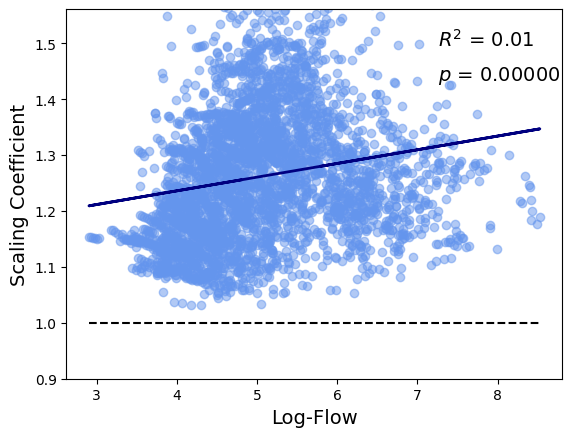

In [75]:
plot_quarter = 'SON'
xs = fit_lrms[plot_quarter].exog[:,1]
ys = fit_lrms[plot_quarter].endog[:]

# Get the model parameters fom OLS regression
intercept, slope = fit_lrrs[plot_quarter].params

# Get R-squared
r_sqr = fit_lrrs['JJA'].rsquared
p_val = fit_lrrs['JJA'].pvalues[1]

# Figure
fig, ax = plt.subplots()
ax.scatter(xs[ys>=1.0], ys[ys>=1.0], alpha = 0.5, color='cornflowerblue')
ax.scatter(xs[ys<1.0], ys[ys<1.0], alpha = 0.5, color='grey')
ax.hlines(1.0, xmin=min(xs), xmax=max(xs), linestyles='dashed', color='black')
ax.plot(xs, intercept + slope * xs, color='navy', linewidth=2)
ax.text(0.75, 0.95, '$R^2$ = %.2f' % r_sqr, transform=ax.transAxes, fontsize=14, verticalalignment='top')
ax.text(0.75, 0.85, '$p$ = %.5f' % p_val, transform=ax.transAxes, fontsize=14, verticalalignment='top')
ax.set_ylim([min(0.9, np.quantile(ys,0.01)), np.quantile(ys, 0.99)])
ax.set_ylabel('Scaling Coefficient', fontsize = 14)
ax.set_xlabel('Log-Flow', fontsize=14)